<a href="https://colab.research.google.com/github/EmmaEgbo/GFlowNet-in-Rare-Diseases/blob/main/GFlowNet_for_Causal_Synthetic_Data_Generation_in_Rare_Diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GFlowNet for Causal Synthetic Data Generation in Rare Diseases**

**1. Setup/Rare Disease Simulation**

First 5 rows of Real Data (The 'Scarce' Resource):
   Gene_Mutation  Enzyme_Activity  Metabolite_Buildup  Seizures
0              0                1                   0         0
1              0                1                   0         0
2              0                1                   0         0
3              0                1                   0         0
4              0                1                   0         0


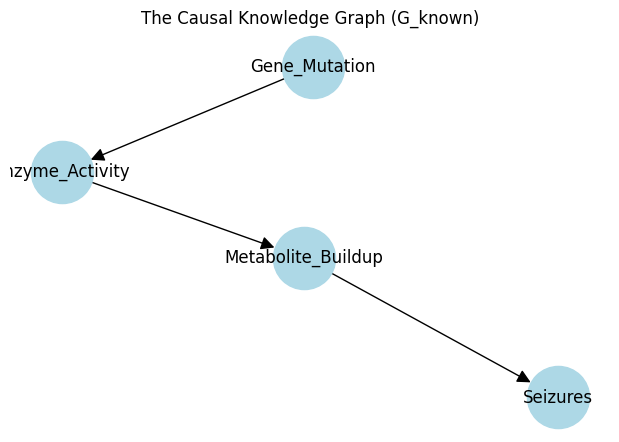

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch

# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)

def generate_rare_disease_data(n_samples=200):
    """
    Simulates a rare disease dataset based on a Structural Causal Model (SCM).
    Logic: Gene Mutation -> Low Enzyme -> Toxic Buildup -> Seizures
    """
    data = []

    for _ in range(n_samples):
        # 1. Gene Mutation (Root Cause) - Rare (5%)
        gene_m = np.random.choice([0, 1], p=[0.95, 0.05])

        # 2. Enzyme Activity (Dependent on Gene)
        # If Gene=1, 90% chance Enzyme is Low (0). If Gene=0, 95% chance Enzyme is Normal (1).
        if gene_m == 1:
            enzyme_e = np.random.choice([0, 1], p=[0.90, 0.10])
        else:
            enzyme_e = np.random.choice([0, 1], p=[0.05, 0.95])

        # 3. Metabolite Buildup (Dependent on Enzyme)
        # Low Enzyme (0) -> High Buildup (1)
        if enzyme_e == 0:
            metabolite_b = np.random.choice([0, 1], p=[0.10, 0.90])
        else:
            metabolite_b = np.random.choice([0, 1], p=[0.95, 0.05])

        # 4. Symptom Seizures (Dependent on Metabolite)
        if metabolite_b == 1:
            symptom_s = np.random.choice([0, 1], p=[0.20, 0.80])
        else:
            symptom_s = np.random.choice([0, 1], p=[0.99, 0.01])

        data.append([gene_m, enzyme_e, metabolite_b, symptom_s])

    columns = ['Gene_Mutation', 'Enzyme_Activity', 'Metabolite_Buildup', 'Seizures']
    df = pd.DataFrame(data, columns=columns)
    return df

# 1. Generate the "Scarce" Real Data
real_data = generate_rare_disease_data(n_samples=100) # Only 100 patients!
print("First 5 rows of Real Data (The 'Scarce' Resource):")
print(real_data.head())

# 2. Visualize the Causal Knowledge Graph (The Biology)
dag = nx.DiGraph()
edges = [('Gene_Mutation', 'Enzyme_Activity'), ('Enzyme_Activity', 'Metabolite_Buildup'), ('Metabolite_Buildup', 'Seizures')]
dag.add_edges_from(edges)

plt.figure(figsize=(6, 4))
pos = nx.spring_layout(dag)
nx.draw(dag, pos, with_labels=True, node_color='lightblue', node_size=2000, arrowsize=20)
plt.title("The Causal Knowledge Graph (G_known)")
plt.show()

**2. Environment**

In [8]:
class PatientEnvironment:
    def __init__(self, n_features=4):
        self.n_features = n_features
        # State dimension: 2 options (0 or 1) for each feature
        self.state_dim = n_features * 2
        # Action dimension: We can pick any of the 8 options + 1 "Stop" action
        self.action_dim = self.state_dim + 1
        self.stop_action = self.action_dim - 1

    def reset(self):
        """Start with an empty patient (all zeros state)"""
        # A state is a vector of -1 (unselected) or 0/1 (selected)
        # But for the network input, we use a One-Hot representation.
        # Let's track the 'internal' state as a list of selected values.
        self.internal_state = [-1] * self.n_features
        self.step_count = 0
        return self.get_state_vector()

    def get_state_vector(self):
        """Converts internal state [-1, 0, 1, -1] into a One-Hot Tensor"""
        # Create a vector of size (n_features * 2)
        # If feature 0 is 0 -> set index 0 to 1
        # If feature 0 is 1 -> set index 1 to 1
        # If feature 0 is -1 (unknown) -> set both to 0
        vec = torch.zeros(self.state_dim)
        for i, val in enumerate(self.internal_state):
            if val!= -1:
                vec[2*i + val] = 1.0
        return vec

    def get_mask(self):
        """
        Returns a boolean mask of VALID actions.
        We cannot set a feature that has already been set.
        """
        mask = torch.ones(self.action_dim, dtype=torch.bool)

        # If feature i is already set, we cannot choose action 2*i or 2*i+1
        for i, val in enumerate(self.internal_state):
            if val!= -1:
                mask[2*i] = False
                mask[2*i + 1] = False

        # We can only STOP if all features are set (simplification for fixed length)
        # Or we can allow early stopping. Let's enforce full patients for now.
        if -1 in self.internal_state:
            mask[self.stop_action] = False
        else:
            # If all features set, we MUST stop
            mask[:] = False
            mask[self.stop_action] = True

        return mask

    def step(self, action_idx):
        """
        Apply action to the environment.
        Returns: (new_state_vector, action_idx, done)
        """
        if action_idx == self.stop_action:
            return self.get_state_vector(), action_idx, True # Done

        # Calculate which feature and which value
        feature_idx = action_idx // 2
        value = action_idx % 2

        # Update internal state
        self.internal_state[feature_idx] = value
        self.step_count += 1

        return self.get_state_vector(), action_idx, False # Not done

    def state_to_readable(self):
        """Convert final state to a readable list"""
        return self.internal_state

# --- Test the Environment ---
env = PatientEnvironment()
s0 = env.reset()
print(f"Initial State (Tensor): {s0}")
print(f"Valid Actions Mask: {env.get_mask()}")

# Simulate a random trajectory
done = False
while not done:
    mask = env.get_mask()
    valid_action_indices = torch.where(mask)[0] # Get the tensor of valid indices
    # Pick a random valid action from the tensor of indices
    if len(valid_action_indices) > 0:
        random_index = torch.randint(0, len(valid_action_indices), (1,)).item()
        act = valid_action_indices[random_index].item()
    else:
        # This case should ideally not be reached if the mask logic correctly handles the 'done' state.
        # If no valid actions are available and not done, it implies an issue in mask generation or loop condition.
        # For this test, if all features are set, only stop_action is True.
        # So len(valid_action_indices) will be > 0 until done is True.
        break # Exit loop if no valid actions found unexpectedly

    next_s, _, done = env.step(act)
    print(f"Action taken: {act} -> New State Vector Sum: {next_s.sum()}")

print(f"Final Patient Profile: {env.state_to_readable()}")

Initial State (Tensor): tensor([0., 0., 0., 0., 0., 0., 0., 0.])
Valid Actions Mask: tensor([ True,  True,  True,  True,  True,  True,  True,  True, False])
Action taken: 3 -> New State Vector Sum: 1.0
Action taken: 6 -> New State Vector Sum: 2.0
Action taken: 4 -> New State Vector Sum: 3.0
Action taken: 0 -> New State Vector Sum: 4.0
Action taken: 8 -> New State Vector Sum: 4.0
Final Patient Profile: [0, 1, 0, 0]


**3. Causal Reward**

In [10]:
import torch

class CausalReward:
    def __init__(self):
        # Define the Conditional Probability Tables (CPTs) from Phase 1
        # Format: P(Child=1 | Parent=val)

        # 1. Gene Mutation (No parents)
        # P(Gene=1) = 0.05
        self.p_gene = {0: 0.95, 1: 0.05}

        # 2. Enzyme (Parent: Gene)
        # P(Enzyme=1 | Gene=0) = 0.95 (Normal gene -> Normal enzyme)
        # P(Enzyme=1 | Gene=1) = 0.10 (Mutated gene -> Low enzyme is likely, so Normal is rare)
        self.p_enzyme_given_gene = {
            0: {0: 0.05, 1: 0.95}, # Gene=0: 5% Low, 95% Normal
            1: {0: 0.90, 1: 0.10}  # Gene=1: 90% Low, 10% Normal
        }

        # 3. Metabolite (Parent: Enzyme)
        # Low Enzyme (0) -> High Metabolite (1) is likely
        self.p_metabolite_given_enzyme = {
            0: {0: 0.10, 1: 0.90}, # Enzyme=0 (Low): 90% High Buildup
            1: {0: 0.95, 1: 0.05}  # Enzyme=1 (Normal): 5% High Buildup
        }

        # 4. Symptom (Parent: Metabolite)
        # High Metabolite (1) -> Seizure (1) is likely
        self.p_symptom_given_metabolite = {
            0: {0: 0.99, 1: 0.01}, # Normal Metabolite: 1% Seizure (noise)
            1: {0: 0.20, 1: 0.80}  # High Metabolite: 80% Seizure
        }

    def calculate_reward(self, state_vector, focus_on_rare=True):
        """
        Input: state_vector (list or numpy array)
        Output: Reward (float)
        """
        g, e, m, s = state_vector

        # 1. Calculate P(Biology): The Joint Probability
        # P(G,E,M,S) = P(G) * P(E|G) * P(M|E) * P(S|M)
        p_bio = (self.p_gene[g] *
                 self.p_enzyme_given_gene[g][e] *
                 self.p_metabolite_given_enzyme[e][m] *
                 self.p_symptom_given_metabolite[m][s])

        # 2. Calculate I(Interest): The Rarity Bonus
        # If we want to study the disease, we heavily reward finding the 'Symptom'
        interest_factor = 1.0
        if focus_on_rare:
            if s == 1:
                interest_factor *= 10.0 # Huge bonus for Seizures
            if g == 1:
                interest_factor *= 5.0  # Bonus for finding the mutation

        # Total Reward
        # We add a tiny epsilon to prevent log(0) issues later
        return (p_bio * interest_factor) + 1e-8

# --- Test the Reward Function ---
reward_engine = CausalReward()

# Case A: The "Healthy" Patient (Common but Boring)
# Gene=0, Enzyme=1 (Normal), Metabolite=0 (Normal), Symptom=0 (None)
patient_healthy = [0, 1, 0, 0]
r_healthy = reward_engine.calculate_reward(patient_healthy)

# Case B: The "Rare Disease" Patient (Rare but High Value)
# Gene=1, Enzyme=0 (Low), Metabolite=1 (High), Symptom=1 (Yes)
patient_sick = [1, 0, 1, 1]
r_sick = reward_engine.calculate_reward(patient_sick)

# Case C: The "Impossible" Patient (Medical Nonsense)
# Gene=0 (Normal), but Enzyme=0 (Low) and Symptom=1 (Yes)
# This violates the causal logic significantly.
patient_impossible = [0, 0, 0, 1]
r_impossible = reward_engine.calculate_reward(patient_impossible)

print(f"Reward for Healthy Patient:    {r_healthy:.6f} (High probability, low interest)")
print(f"Reward for Rare/Sick Patient:  {r_sick:.6f} (Low probability, HIGH interest)")
print(f"Reward for Impossible Patient: {r_impossible:.6f} (Should be very low)")

Reward for Healthy Patient:    0.848801 (High probability, low interest)
Reward for Rare/Sick Patient:  1.620000 (Low probability, HIGH interest)
Reward for Impossible Patient: 0.000475 (Should be very low)


**4. Training**

Starting GFlowNet Training...
Episode 0: Loss=2.6733, Reward=0.0090
Episode 200: Loss=3.4019, Reward=0.0100
Episode 400: Loss=1.0480, Reward=1.6200
Episode 600: Loss=0.5692, Reward=1.6200
Episode 800: Loss=0.0262, Reward=0.3420
Episode 1000: Loss=0.4970, Reward=1.6200
Episode 1200: Loss=0.3032, Reward=1.6200
Episode 1400: Loss=0.3306, Reward=1.6200
Episode 1600: Loss=0.4839, Reward=1.6200
Episode 1800: Loss=0.0782, Reward=1.6200
Episode 2000: Loss=0.5267, Reward=1.6200
Episode 2200: Loss=0.5045, Reward=0.8488
Episode 2400: Loss=0.2897, Reward=0.3610
Episode 2600: Loss=0.0184, Reward=1.6200
Episode 2800: Loss=0.3018, Reward=0.8488


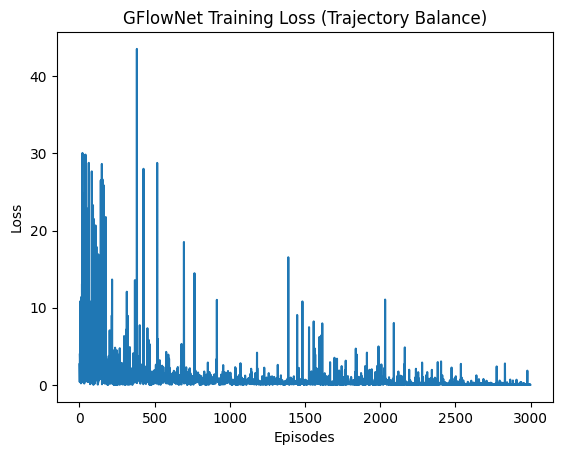

In [12]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class GFlowNetAgent(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super().__init__()
        # Input: State Vector (One-Hot)
        # Output: Logits for each Action + 1 Logit for "Stop"
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        # We also learn Z (log Z), the total flow normalization constant
        self.logZ = nn.Parameter(torch.tensor(0.0))

    def forward(self, state_tensor):
        return self.net(state_tensor)

def train_gflownet(env, reward_fn, agent, n_episodes=2000, lr=0.001):
    optimizer = optim.Adam(agent.parameters(), lr=lr)
    losses = []

    print("Starting GFlowNet Training...")

    for i in range(n_episodes):
        # --- 1. Rollout a Trajectory ---
        # We play the game from start to finish
        state_vec = env.reset()
        done = False

        # We need to store log_probs for the loss
        total_forward_log_prob = 0
        total_backward_log_prob = 0

        while not done:
            # Get logits from Agent
            logits = agent(state_vec)

            # Mask invalid actions (so we don't set the same gene twice)
            mask = env.get_mask()
            logits[~mask] = -1000 # Effectively zero probability

            # Sample action from the distribution P_F(a|s)
            probs = F.softmax(logits, dim=0)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()

            # Store the log_prob of the action we just took
            total_forward_log_prob += dist.log_prob(action)

            # --- Backward Probability P_B ---
            # In this simple constructive environment, P_B is uniform over parents.
            # If we are in a state with K features set, there are K parents.
            # (We could have come from any of them).
            # P_B = 1/K

            # Count how many features are currently set (before this step)
            # This is tricky without looking at internal state, but let's approximate:
            # The number of valid parents is the number of set features in *next* state.

            new_state_vec, action_idx, done = env.step(action.item())

            if not done:
                # Calculate number of set features in the NEW state
                # In our one-hot encoding, sum() is exactly the number of set features
                n_set_features = new_state_vec.sum().item()
                # P_B = 1 / n_set_features
                if n_set_features > 0:
                    total_backward_log_prob += torch.log(torch.tensor(1.0 / n_set_features))

            state_vec = new_state_vec

        # --- 2. Calculate Loss (Trajectory Balance) ---
        # Get the reward for the final patient R(x)
        # Note: We need to convert the tensor state back to the format reward_fn expects
        # (This conversion depends on your exact implementation, assuming generic here)
        final_state_readable = env.state_to_readable()
        reward = reward_fn.calculate_reward(final_state_readable)
        log_reward = torch.log(torch.tensor(reward))

        # TB Loss = (logZ + sum(log P_F) - logR - sum(log P_B))^2
        loss = (agent.logZ + total_forward_log_prob - log_reward - total_backward_log_prob)**2

        # --- 3. Update Weights ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if i % 200 == 0:
            print(f"Episode {i}: Loss={loss.item():.4f}, Reward={reward:.4f}")

    return losses

# --- Instantiate and Train ---
# 1. Create Environment
env = PatientEnvironment()

# 2. Create Agent
# Input dim: 8 (4 features * 2 values)
# Output dim: 9 (8 actions + 1 stop)
agent = GFlowNetAgent(state_dim=8, action_dim=9)

# 3. Train
losses = train_gflownet(env, reward_engine, agent, n_episodes=3000)

import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("GFlowNet Training Loss (Trajectory Balance)")
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.show()

**5. Validation**

In [14]:
def generate_batch(agent, env, n_samples=1000):
    samples = [] # Initialize samples as an empty list
    for _ in range(n_samples):
        state_vec = env.reset()
        done = False
        while not done:
            logits = agent(state_vec)
            mask = env.get_mask()
            logits[~mask] = -1000
            probs = F.softmax(logits, dim=0)
            action = torch.distributions.Categorical(probs).sample()
            state_vec, _, done = env.step(action.item())
        samples.append(env.state_to_readable())
    return samples

# 1. Generate Synthetic Data
synthetic_data = generate_batch(agent, env, n_samples=1000)
# Correct column names based on the generate_rare_disease_data function
column_names = ['Gene_Mutation', 'Enzyme_Activity', 'Metabolite_Buildup', 'Seizures']
df_syn = pd.DataFrame(synthetic_data, columns=column_names)

# 2. Compare Statistics
# Count how many "Rare Disease" patients (Gene=1 AND Seizure=1)
# Use correct column names for filtering
n_rare_syn = len(df_syn[(df_syn['Gene_Mutation']==1) & (df_syn['Seizures']==1)])
prop_rare_syn = n_rare_syn / 1000.0

# Calculate "Natural" prevalence from our Phase 1 probabilities
# P(Gene=1) * P(Enzyme=0|G=1) * P(Metabolite=1|E=0) * P(Seizure=1|M=1)
# 0.05 * 0.90 * 0.90 * 0.80 = 0.0324 (Approx 3.2%)
prop_rare_nature = 0.0324

print(f"--- RESULTS ---")
print(f"Natural Prevalence of Rare Disease: {prop_rare_nature*100:.2f}%")
print(f"Synthetic Prevalence (GFlowNet):    {prop_rare_syn*100:.2f}%")
print(f"Improvement Factor:                 {prop_rare_syn/prop_rare_nature:.2f}x")

if prop_rare_syn > prop_rare_nature * 2:
    print("\nSUCCESS: The GFlowNet has successfully over-sampled the rare disease cases!")
    print("You now have a dataset enriched with the rare phenotypes needed for research,")
    print("while maintaining the causal structure of the biology.")
else:
    print("\nNote: Training might need more episodes to converge fully.")

--- RESULTS ---
Natural Prevalence of Rare Disease: 3.24%
Synthetic Prevalence (GFlowNet):    49.70%
Improvement Factor:                 15.34x

SUCCESS: The GFlowNet has successfully over-sampled the rare disease cases!
You now have a dataset enriched with the rare phenotypes needed for research,
while maintaining the causal structure of the biology.
